**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains some sample code of chapter 14._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
import sys

import sklearn
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## ResNet-34

In [3]:
from functools import partial

# A convenient custom layer.
# Partial functions allow us to fix a certain number of arguments of 
# a function and generate a new function.
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    # Por cada capa introduce los inputs, y cuenta los skip layers
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In the constructor, we
create all the layers we will need: the main layers are the ones on the right side of the
diagram, and the skip layers are the ones on the left (only needed if the stride is
greater than 1). Then in the call() method, we make the inputs go through the main
layers and the skip layers (if any), then we add both outputs and apply the activation
function.

Next, we can build the ResNet-34 using a Sequential model, since it’s really just a
long sequence of layers (we can treat each residual unit as a single layer now that we
have the ResidualUnit class):

In [4]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

The only slightly tricky part in this code is the loop that adds the ResidualUnit layers
to the model: as explained earlier, the first 3 RUs have 64 filters, then the next 4 RUs
have 128 filters, and so on. We then set the stride to 1 when the number of filters is
the same as in the previous RU, or else we set it to 2. Then we add the ResidualUnit ,
and finally we update prev_filters .

It is amazing that in fewer than 40 lines of code, we can build the model that won the
ILSVRC 2015 challenge! This demonstrates both the elegance of the ResNet model
and the expressiveness of the Keras API. Implementing the other CNN architectures
is not much harder. However, Keras comes with several of these architectures built in,
so why not use them instead?

## Using a Pretrained Model

In general, you won’t have to implement standard models like GoogLeNet or ResNet
manually, since pretrained networks are readily available with a single line of code in
the keras.applications package. For example, you can load the ResNet-50 model,
pretrained on ImageNet, with the following line of code:

In [6]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [7]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 2s 0us/step


A ResNet-50 model expects 224 × 224-pixel images. There are sevaral function to do this:

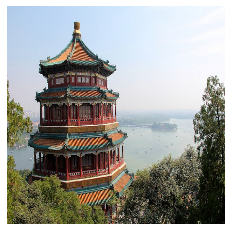

In [8]:
# Does not preserve aspect ratio
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


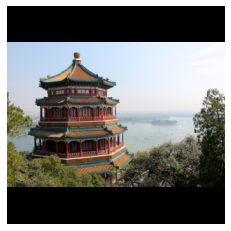

In [9]:
# Preserves aspect ratio, but padding may be troublesome
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

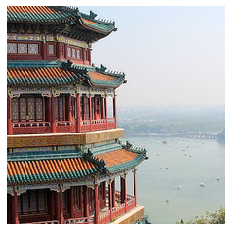

In [10]:
# Either crops large images, or pads small ones.
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

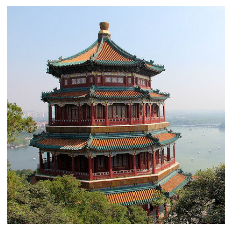

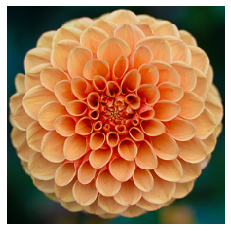

In [11]:
# It is sometimes better to define a bounding box, but this is troublesome to 
# do for many images
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

The pretrained models assume that the images are preprocessed in a specific way. In
some cases they may expect the inputs to be scaled from 0 to 1, or –1 to 1, and so on.
Each model provides a preprocess_input() function that you can use to preprocess
your images. These functions assume that the pixel values range from 0 to 255, so we
must multiply them by 255 (since earlier we scaled them to the 0–1 range):

In [12]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
# Now we can use the pretrained model to make predictions:
Y_proba = model.predict(inputs)

As usual, the output Y_proba is a matrix with one row per image and one column per
class (in this case, there are 1,000 classes).

In [13]:
Y_proba.shape

(2, 1000)

In [14]:
Y_proba

array([[7.3550033e-09, 2.1553369e-08, 7.4701001e-09, ..., 1.7062604e-09,
        1.1173549e-07, 3.3829206e-08],
       [2.3477138e-07, 7.0271467e-06, 4.0480535e-07, ..., 5.4022996e-05,
        3.6675727e-05, 1.3372209e-04]], dtype=float32)

If you want to display the top K predictions, including the class name and the estimated probability of each predicted class,
use the decode_predictions() function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing
the class identifier, its name, and the corresponding confidence score:

In [15]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=10)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {}  -  {:14s}    {:.3f} % ".format(class_id, name, y_proba * 100))
    print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845  -  palace            43.393 % 
  n02825657  -  bell_cote         43.075 % 
  n03781244  -  monastery         11.695 % 
  n02980441  -  castle            0.810 % 
  n09332890  -  lakeside          0.173 % 
  n04346328  -  stupa             0.150 % 
  n02859443  -  boathouse         0.147 % 
  n03028079  -  church            0.139 % 
  n04435653  -  tile_roof         0.083 % 
  n04486054  -  triumphal_arch    0.067 % 

Image #1
  n04522168  -  vase              53.965 % 
  n07930864  -  cup               9.524 % 
  n11939491  -  daisy             4.966 % 
  n03443371  -  goblet            3.842 % 
  n03916031  -  perfume           3.312 % 
  n13040303  -  stinkhorn         1.816 % 
  n03637318  -  lampshade         1.781 % 
  n02206856  -  bee               1.661 % 
  n02948072  -  candle            1.552 % 
  n03530642  -  honeycomb         1.424 % 



The correct classes (monastery and daisy) appear in the top three results for both
images. That’s pretty good, considering that the model had to choose from among
1,000 classes.

But what if you want to use an image classifier for classes of images that are not part
of ImageNet? In that case, you may still benefit from the pretrained models to perform transfer learning.

## Pretrained Models for Transfer Learning

If you want to build an image classifier but you do not have enough training data,
then it is often a good idea to reuse the lower layers of a pretrained model.
For example, let’s train a model to classify pictures of flowers,
reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow
Datasets.

In [16]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [17]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [18]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [19]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [20]:
n_classes = info.features["label"].num_classes
n_classes

5

In [21]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

Note that you can get information about the dataset by setting with_info=True . Here,
we get the dataset size and the names of the classes. Unfortunately, there is only a
"train" dataset, no test set or validation set, so we need to split the training set. The
TF Datasets project provides an API for this. For example, let’s take the first 10% of
the dataset for testing, the next 15% for validation, and the remaining 75% for
training:

In [22]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

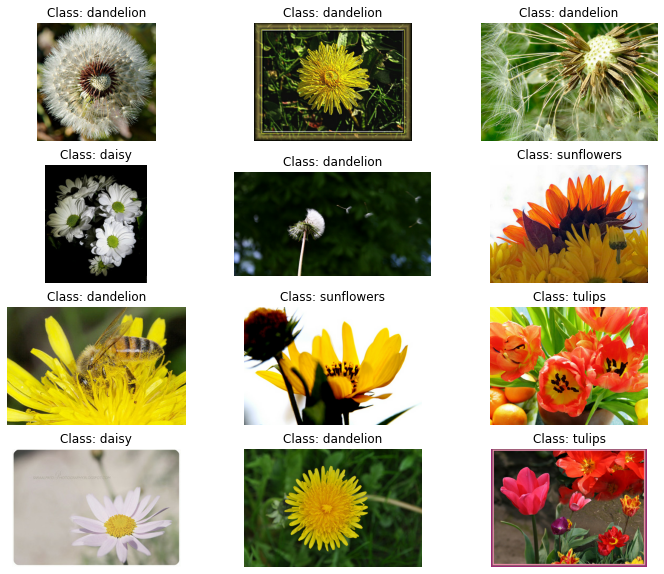

In [23]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(12):
    index += 1
    plt.subplot(4, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Next we must preprocess the images. The CNN expects 224 × 224 images, so we need
to resize them. We also need to run the images through Xception’s prepro
cess_input() function:

In [24]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

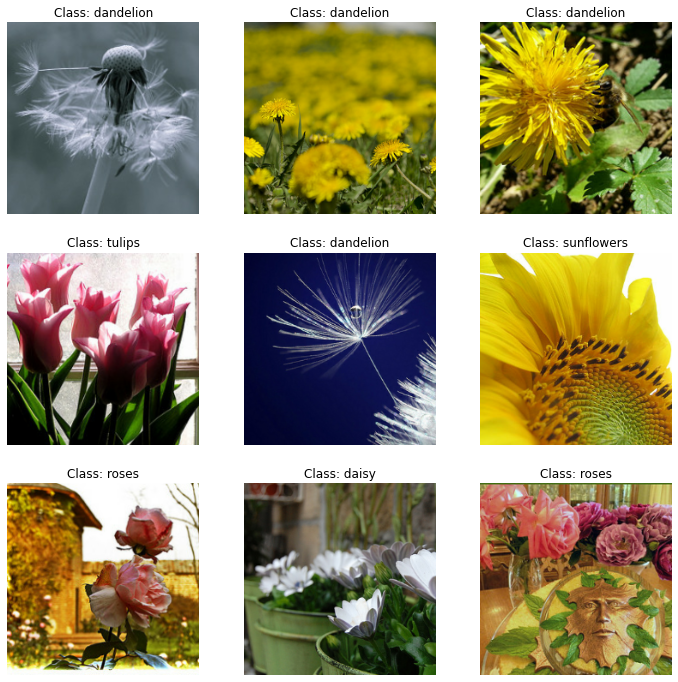

In [25]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

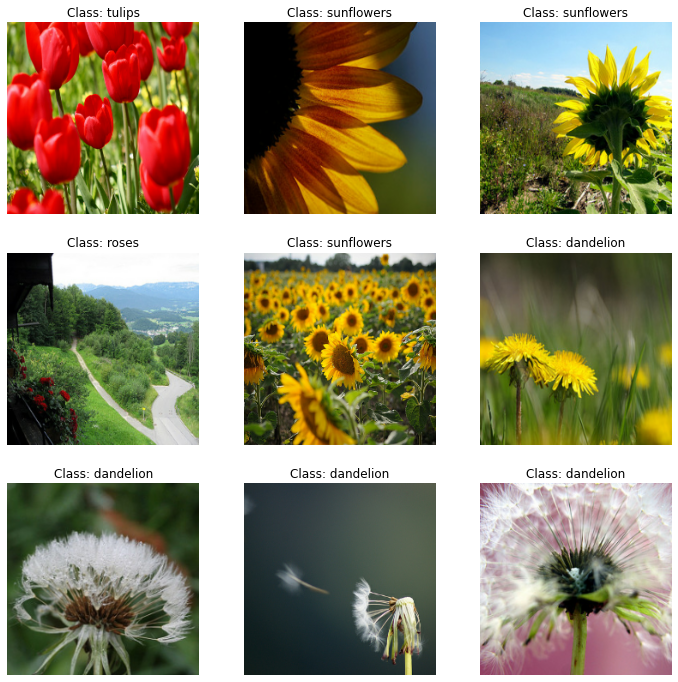

In [26]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the
network by setting include_top=False : this excludes the global average pooling layer
and the dense output layer. We then add our own global average pooling layer, based
on the output of the base model, followed by a dense output layer with one unit per
class, using the softmax activation function. Finally, we create the Keras Model :

In [27]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [28]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_36
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_37
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_38
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [ ]:
# it’s usually a good idea to freeze the weights of the 
# pretrained layers, at least at the beginning of training:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


After training the model for a few epochs, its validation accuracy should reach about
75–80% and stop making much progress. This means that the top layers are now
pretty well trained, so we are ready to unfreeze all the layers (or you could try
unfreezing just the top ones) and continue training (don’t forget to compile the
model when you freeze or unfreeze layers). This time we use a much lower learning
rate to avoid damaging the pretrained weights:

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

It will take a while, but this model should reach around 95% accuracy on the test set.
With that, you can start training amazing image classifiers!